# Imports

In [1]:
import os
import base64
import joblib
import pandas as pd
import numpy as np
import category_encoders as ce
import json
import joblib
import pickle
import math
import requests
from copy import deepcopy
import seaborn as sns
from uuid import uuid4

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, power_transform, RobustScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (precision_score,
                            recall_score,
                            f1_score,
                            accuracy_score,
                            roc_auc_score,
                            confusion_matrix,
                            ConfusionMatrixDisplay,
                            make_scorer,
                            RocCurveDisplay,
                            auc,
                            roc_curve,
                            precision_recall_curve)

from sklearn.base import BaseEstimator, TransformerMixin

from pandas_profiling import ProfileReport

from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.style.use('ggplot')
%matplotlib inline

# Custom transformer imports

In [2]:
# WIP preprocessor which assigns categories and compresses some code
from custom_transformers.preprocessor import ColumnConverter

# WIP ordinal category preprocessor
from custom_transformers.custom_ordinal_encoder import custom_oe

#WIP column selector
from custom_transformers.featureselector import SelectColumns

# WIP onehot category preprocessor
from custom_transformers.custom_onehot_encoder import custom_one_hot

# WIP onehot category preprocessor
from custom_transformers.custom_impute_scale import custom_impute_scale


# Functions

In [3]:
def load_train_data():
    df = pd.read_csv(os.path.join("data", "train_data.csv"))
    return df

data_train = load_train_data()

In [4]:
def assign_index(df, indexcol: str):
    _df = df.copy()
    _df = _df.set_index(indexcol)
    return _df

In [5]:
def build_target(df, target: str):
    _df = df.copy()
    _df[target] = np.where(_df[target]== 'Yes', True, False)
    return _df

# Function to test if we satisfied requirements:

The first step will make a copy of the X_test and apply the custom converter for the columns - it will update the categories we are interested in (avoid duplicates etc)

In [6]:
def verify_no_discrimination(X_test,
                             y_true,
                             y_pred,
                             sensitive_columns = [],
                             max_diff=0.1,
                             average='weighted'):    
    # Use this as a template to get output:
    #f1_scores, diff, is_satisfied  = verify_no_discrimination(X_test,
    #                                                          y_test,
    #                                                          y_pred,
    #                                                          sensitive_column=['Self-defined ethnicity', 'race'] etc
    #                                                          max_diff=0.15 )
    #f1_scores, diff, is_satisfied
    
    _df = X_test.copy()
    
    results = {}
    
    cc = ColumnConverter()
    _df = cc.fit_transform(_df)
    
    for column in sensitive_columns:  
        sensitive_classes = _df[column].unique()
        is_satisfied = True
        f1_scores = {}
        
        for sensitive_class in sensitive_classes:
            mask = (_df[column] == sensitive_class)
            if mask.sum():
                f1_scores[sensitive_class] = f1_score(y_true[mask],
                                                      y_pred[mask],
                                                      pos_label=1,
                                                      labels=np.unique(y_pred[mask]))
        
        diff = np.max(list(f1_scores.values())) - np.min(list(f1_scores.values()))
        if diff > max_diff:
            is_satisfied = False
        
        results[column] = [f1_scores, diff, is_satisfied]
    
    return results

# Loading data

In [7]:
target = 'readmitted'
index_col = 'admission_id'

In [8]:
data_train = load_train_data()
data_train = assign_index(data_train, index_col)
data_train = build_target(data_train, target)

In [9]:
#List of all features (n=numerical, uc=unordered actegory, oc=ordered category, b=boolean)

all_features = ['patient_id', #identifier
                'race', #uc
                'gender', #uc
                'age', #oc
                'weight', #oc               
                'admission_type_code', #uc
                'discharge_disposition_code', #uc
                'admission_source_code', #uc
                'time_in_hospital', #n
                'payer_code', #uc
                'medical_specialty', #uc
                'has_prosthesis', #b
                'complete_vaccination_status', #uc
                'num_lab_procedures', #n
                'num_procedures', #n
                'num_medications', #n
                'number_outpatient', #n
                'number_emergency', #n
                'number_inpatient', #n
                'diag_1', #uc
                'diag_2', #uc
                'diag_3', #uc
                'number_diagnoses', #n
                'blood_type', #uc
                'hemoglobin_level', #n
                'blood_transfusion', #b
                'max_glu_serum', #oc
                'A1Cresult', #oc
                'diuretics', #b
                'insulin', #b
                'change', #b
                'diabetesMed'] #b]

num_features = ['time_in_hospital', 
                'num_lab_procedures',
                'num_procedures',
                'num_medications',
                'number_outpatient',
                'number_emergency',
                'number_inpatient',
                'number_diagnoses',
                'hemoglobin_level']

bool_features = ['has_prosthesis',
                 'blood_transfusion',
                 'diuretics',
                 'insulin',
                 'change',
                 'diabetesMed']

cat_features = ['race',
                'gender',
                'admission_type_code', 
                'discharge_disposition_code',
                'admission_source_code', 
                'payer_code',
                'medical_specialty',
                'diag_1',
                'diag_2',
                'diag_3',
                'blood_type']

ord_cat_features = ['age',
                    'weight',
                    'max_glu_serum',
                    'A1Cresult',
                    'complete_vaccination_status',]

# missing features: date of admission and date of release

### Test train split

In [10]:
# Convert target to boolean

# We have a small portion kept aside because of our random undersampling approach where we lose a lot of train data 
#df_train, df_test = train_test_split(data_train, test_size=0.1, random_state=42, stratify=data_train[target])

df_train, df_test = train_test_split(data_train, test_size=0.1, random_state=42, stratify=None, shuffle=False)

### Dealing with unbalanced train data:
1. Going to use random oversampling

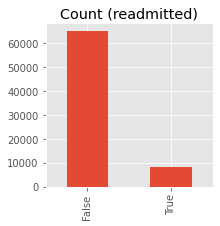

In [11]:
plt.rcParams["figure.figsize"] = [3, 3]
df_train[target].value_counts().plot(kind='bar', title='Count (readmitted)');

In [12]:
# get counts and split tables
count_f, count_t = df_train[target].value_counts()
df_f = df_train[df_train[target] == False]
df_t = df_train[df_train[target] == True]

### Random oversampling of the positive (True) class

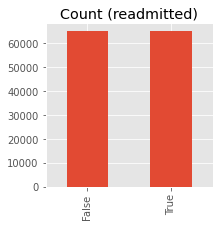

In [13]:
# oversampling (lots of duplication of positive classes)
df_t_oversampled = df_t.sample(count_f, replace=True)
df_train_oversampled = pd.concat([df_t_oversampled, df_f], axis=0)
#sort it to maintain some kind of order
df_train_oversampled = df_train_oversampled.sort_index()
#plot it
df_train_oversampled[target].value_counts().plot(kind='bar', title='Count (readmitted)');

### Test train split and selection

In [14]:
# # without random oversampling
# X_train = df_train.drop(target, axis=1)
# y_train = df_train[target]

# with random oversampling
X_train = df_train_oversampled.drop(target, axis=1)
y_train = df_train_oversampled[target]

#test data
X_test = df_test.drop(target, axis=1)
y_test = df_test[target]

In [15]:
selected_features = ['time_in_hospital', 
                     'num_lab_procedures',
                     'num_procedures',
                     'num_medications',
                     'number_outpatient',
                     'number_emergency',
                     'number_inpatient',
                     'number_diagnoses',
                     'hemoglobin_level',
                     
                     #'has_prosthesis',
                     'blood_transfusion',
                     #'diuretics',
                     'insulin',
                     'change',
                     'diabetesMed',
                     
                     'race',
                     'gender',
                     'admission_type_code', 
                     'discharge_disposition_code',
                     'admission_source_code', 
                     'payer_code',
                     #'medical_specialty',
                     #'complete_vaccination_status',
                     'blood_type',
                     'diag_1',
                     'diag_2',
                     'diag_3',
                     
                     'max_glu_serum',
                     'A1Cresult',
                     'age',
                     #'weight'
                    ]

In [16]:
num_feats = [feat for feat in selected_features if feat in num_features]
cat_feats = [feat for feat in selected_features if feat in cat_features+bool_features+ord_cat_features]
bool_feats = [feat for feat in selected_features if feat in bool_features]
ord_cat_feats = [feat for feat in selected_features if feat in ord_cat_features]

In [17]:
ord_cat_features = ['age',
                    'weight', #lots of missing or unknown values
                    'max_glu_serum',
                    'A1Cresult',
                    'complete_vaccination_status',]

In [18]:
cat_features = ['race', #done
                'gender', #done
                'admission_type_code', #done 
                'discharge_disposition_code', #done
                'admission_source_code', # done 
                'payer_code', #done (now the insurance column)
                #'medical_specialty', #done (any specialty over 100 - lets see how bad it gets)
                'diag_1',
                'diag_2',
                'diag_3',
                'blood_type'
               ] #dropping blood type

1. Not using blood type
1. Not using weight
1. Not using diagnoses: probably linked to medical specialty
    1. Will be added in the next version
1. Admission source not yet included
1. Race, gender and payer code (SP=uninsured) will not be used to model

##### Processing Diagnoses:
1. High cardinality (and possibly redundant information due to overlpa with the speecialty?)

In [19]:
# This needs to become a custom pipeline - and we need different scalers here

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())]) #StandardScaler or MinMaxScaler
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', ce.OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_feats),
        ('cat', categorical_transformer, cat_features)],
remainder="passthrough",sparse_threshold=0)

# Random Forest

In [20]:
pipeline = make_pipeline(
    ColumnConverter(), #Does quick clean up, assigns datatypes and categories
    custom_oe(), #Handles encoding of ordinal variable
    SelectColumns(cols=selected_features),
    preprocessor, #uses preprocessor defined above
    RandomForestClassifier(max_depth=10,
                           class_weight="balanced",
                           random_state=42, n_jobs=-1,
                           n_estimators = 1000,
                           criterion = 'gini',
                           max_features = 'auto',
                           bootstrap = False),
)
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print("f1 score: %s" % (f1_score(y_test, y_pred)))
print("recall score: %s" % (recall_score(y_test, y_pred)))
print("precision score: %s" % (precision_score(y_test, y_pred)))
print("discrimination results:")

f1 score: 0.28256782164920763
recall score: 0.6059907834101382
precision score: 0.18423817863397549
discrimination results:


In [21]:
verify_no_discrimination(X_test=X_test, y_true=y_test, y_pred=y_pred, sensitive_columns = ['medical_specialty', 'payer_code','gender','race', 'age', 'admission_source_code'])

/home/yash/.virtualenvs/bootcamp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/yash/.virtualenvs/bootcamp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


{'medical_specialty': [{'cardiology': 0.18181818181818182,
   'unknown': 0.2877406281661601,
   'internalmedicine': 0.23391812865497075,
   'surgery-vascular': 0.3636363636363636,
   'emergency/trauma': 0.27963525835866265,
   'family/generalpractice': 0.3445692883895131,
   'obstetricsandgynecology': 0.0,
   'nephrology': 0.3373493975903615,
   'psychiatry': 0.24242424242424246,
   'pediatrics-endocrinology': 0.0,
   'surgery-cardiovascular/thoracic': 0.0,
   'pulmonology': 0.4210526315789473,
   'other': 0.3243243243243243,
   'surgery-general': 0.34545454545454546,
   'orthopedics': 0.27272727272727276,
   'urology': 0.2,
   'oncology': 0.3076923076923077,
   'radiologist': 0.1739130434782609,
   'orthopedics-reconstructive': 0.23809523809523808,
   'physicalmedicineandrehabilitation': 0.25,
   'neurology': 0.28571428571428575,
   'gastroenterology': 0.26086956521739124,
   'surgery-neuro': 0.25,
   'hematology/oncology': 0.36363636363636365,
   'pediatrics': 0.4444444444444444},
  

In [22]:
plt.rcParams["figure.figsize"] = [3, 3]

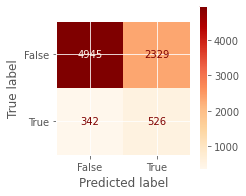

In [23]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred, labels = pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(cmap="OrRd");

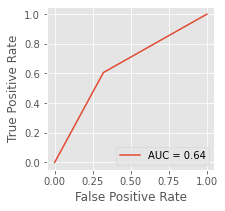

In [24]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=None)
display.plot()
plt.show()

### Evaluation and setting threshold:
1. The client wants at least 50% to be correct

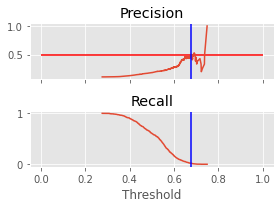

In [25]:
y_pred_probas = pipeline.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_probas)
min_index = [i for i, prec in enumerate(precision) if prec >= 0.5][0]
threshold_rq = thresholds[min_index]
y_pred = (y_pred_probas >= threshold_rq)
plt.rcParams["figure.figsize"] = [4, 3]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_probas)
precision = precision[:-1]
recall = recall[:-1]
fig=plt.figure()
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
ax1.hlines(y=0.5,xmin=0, xmax=1, colors='red')
ax1.plot(thresholds,precision)
ax2.plot(thresholds,recall)
ax1.get_shared_x_axes().join(ax1, ax2)
ax1.set_xticklabels([])
plt.xlabel('Threshold')
ax1.set_title('Precision')
ax1.axvline(x=threshold_rq, color='blue')
ax2.set_title('Recall')
ax2.axvline(x=threshold_rq, color='blue')
fig.tight_layout()
plt.show()

In [26]:
print("f1 score: %s" % (f1_score(y_test, y_pred)))
print("recall score: %s" % (recall_score(y_test, y_pred)))
print("precision score: %s" % (precision_score(y_test, y_pred)))
print("discrimination results:")

f1 score: 0.04194260485651213
recall score: 0.021889400921658985
precision score: 0.5
discrimination results:


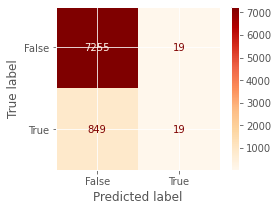

In [27]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred, labels = pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(cmap="OrRd");

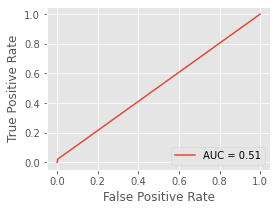

In [28]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=None)
display.plot()
plt.show()

# Gradient Boosting

In [29]:
pipeline = make_pipeline(
    ColumnConverter(), #Does quick clean up, assigns datatypes and categories
    custom_oe(), #Handles encoding of ordinal variable
    SelectColumns(cols=selected_features),
    preprocessor, #uses preprocessor defined above
    GradientBoostingClassifier(learning_rate=.05,
                               n_estimators=100,
                               subsample=0.1,
                               n_iter_no_change=10,
                               max_features = None,
                               random_state=42,
                               validation_fraction = 0.1,
                               criterion = 'friedman_mse')
)
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print("f1 score: %s" % (f1_score(y_test, y_pred)))
print("recall score: %s" % (recall_score(y_test, y_pred)))
print("precision score: %s" % (precision_score(y_test, y_pred)))
print("discrimination results:")

f1 score: 0.28222109016811003
recall score: 0.6382488479262672
precision score: 0.18116415958142576
discrimination results:


In [30]:
verify_no_discrimination(X_test=X_test, y_true=y_test, y_pred=y_pred, sensitive_columns = ['medical_specialty', 'payer_code','gender','race', 'age', 'admission_source_code'])

/home/yash/.virtualenvs/bootcamp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/yash/.virtualenvs/bootcamp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


{'medical_specialty': [{'cardiology': 0.16363636363636364,
   'unknown': 0.28739002932551316,
   'internalmedicine': 0.23443223443223446,
   'surgery-vascular': 0.4347826086956522,
   'emergency/trauma': 0.27988338192419826,
   'family/generalpractice': 0.3391003460207613,
   'obstetricsandgynecology': 0.0,
   'nephrology': 0.35955056179775274,
   'psychiatry': 0.2857142857142857,
   'pediatrics-endocrinology': 0.0,
   'surgery-cardiovascular/thoracic': 0.1,
   'pulmonology': 0.38095238095238093,
   'other': 0.27906976744186046,
   'surgery-general': 0.31932773109243695,
   'orthopedics': 0.26666666666666666,
   'urology': 0.16666666666666669,
   'oncology': 0.26666666666666666,
   'radiologist': 0.23076923076923078,
   'orthopedics-reconstructive': 0.2222222222222222,
   'physicalmedicineandrehabilitation': 0.33333333333333337,
   'neurology': 0.25,
   'gastroenterology': 0.27272727272727276,
   'surgery-neuro': 0.25,
   'hematology/oncology': 0.46153846153846156,
   'pediatrics': 0.6

In [31]:
plt.rcParams["figure.figsize"] = [3, 3]

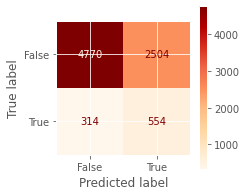

In [32]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred, labels = pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(cmap="OrRd");

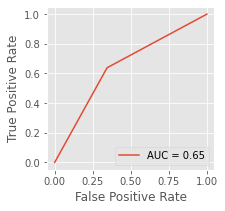

In [33]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=None)
display.plot()
plt.show()

# XGBoost

In [34]:
import xgboost as xgb

In [35]:
pipeline = make_pipeline(
    ColumnConverter(), #Does quick clean up, assigns datatypes and categories
    custom_oe(), #Handles encoding of ordinal variable
    SelectColumns(cols=selected_features),
    preprocessor, #uses preprocessor defined above
    xgb.XGBClassifier(tree_method="approx")
)
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print("f1 score: %s" % (f1_score(y_test, y_pred)))
print("recall score: %s" % (recall_score(y_test, y_pred)))
print("precision score: %s" % (precision_score(y_test, y_pred)))
print("discrimination results:")

/home/yash/.virtualenvs/bootcamp/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:28:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
f1 score: 0.261236802413273
recall score: 0.4988479262672811
precision score: 0.17695136902329384
discrimination results:


In [36]:
verify_no_discrimination(X_test=X_test, y_true=y_test, y_pred=y_pred, sensitive_columns = ['medical_specialty', 'payer_code','gender','race', 'age', 'admission_source_code'])

/home/yash/.virtualenvs/bootcamp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


{'medical_specialty': [{'cardiology': 0.09259259259259259,
   'unknown': 0.27909669947886506,
   'internalmedicine': 0.23348017621145375,
   'surgery-vascular': 0.2,
   'emergency/trauma': 0.2508710801393728,
   'family/generalpractice': 0.2641509433962264,
   'obstetricsandgynecology': 0.0,
   'nephrology': 0.3333333333333333,
   'psychiatry': 0.23076923076923078,
   'pediatrics-endocrinology': 0.0,
   'surgery-cardiovascular/thoracic': 0.0,
   'pulmonology': 0.3684210526315789,
   'other': 0.30303030303030304,
   'surgery-general': 0.2857142857142857,
   'orthopedics': 0.3125,
   'urology': 0.15384615384615385,
   'oncology': 0.4,
   'radiologist': 0.0,
   'orthopedics-reconstructive': 0.21428571428571427,
   'physicalmedicineandrehabilitation': 0.25,
   'neurology': 0.0,
   'gastroenterology': 0.4444444444444444,
   'surgery-neuro': 0.0,
   'hematology/oncology': 0.2,
   'pediatrics': 0.28571428571428575},
  0.4444444444444444,
  False],
 'payer_code': [{'insured': 0.249201277955271

In [37]:
plt.rcParams["figure.figsize"] = [3, 3]

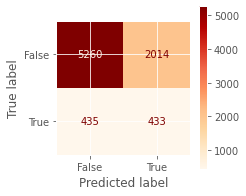

In [38]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred, labels = pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(cmap="OrRd");

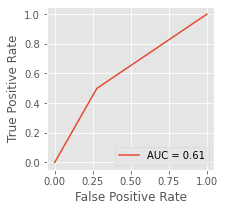

In [39]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=None)
display.plot()
plt.show()

# Balanced Random Forest

In [40]:
from imblearn.ensemble import BalancedRandomForestClassifier

In [41]:
# # without random oversampling
X_train = df_train.drop(target, axis=1)
y_train = df_train[target]

# with random oversampling
# X_train = df_train_oversampled.drop(target, axis=1)
# y_train = df_train_oversampled[target]

#test data
X_test = df_test.drop(target, axis=1)
y_test = df_test[target]

In [49]:
pipeline = make_pipeline(
    ColumnConverter(), #Does quick clean up, assigns datatypes and categories
    custom_oe(), #Handles encoding of ordinal variable
    SelectColumns(cols=selected_features),
    preprocessor, #uses preprocessor defined above
    BalancedRandomForestClassifier(max_depth=None,
                                   random_state=42, 
                                   n_jobs=-1,
                                   n_estimators = 1000,
                                   criterion = 'gini',
                                   bootstrap = True,
                                   max_samples = 0.1,
                                   oob_score = True,
                                   class_weight = 'balanced',
                                   sampling_strategy = 'all'),
)
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print("f1 score: %s" % (f1_score(y_test, y_pred)))
print("recall score: %s" % (recall_score(y_test, y_pred)))
print("precision score: %s" % (precision_score(y_test, y_pred)))
print("discrimination results:")

f1 score: 0.2814278323848939
recall score: 0.6267281105990783
precision score: 0.18145430286857905
discrimination results:


In [50]:
verify_no_discrimination(X_test=X_test, y_true=y_test, y_pred=y_pred, sensitive_columns = ['medical_specialty', 'payer_code','gender','race', 'age', 'admission_source_code'])

/home/yash/.virtualenvs/bootcamp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/yash/.virtualenvs/bootcamp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


{'medical_specialty': [{'cardiology': 0.15652173913043477,
   'unknown': 0.2885085574572127,
   'internalmedicine': 0.2509505703422053,
   'surgery-vascular': 0.3333333333333333,
   'emergency/trauma': 0.26198083067092653,
   'family/generalpractice': 0.32989690721649484,
   'obstetricsandgynecology': 0.0,
   'nephrology': 0.3157894736842105,
   'psychiatry': 0.25,
   'pediatrics-endocrinology': 0.0,
   'surgery-cardiovascular/thoracic': 0.11764705882352941,
   'pulmonology': 0.358974358974359,
   'other': 0.30769230769230765,
   'surgery-general': 0.31666666666666665,
   'orthopedics': 0.30769230769230765,
   'urology': 0.15384615384615385,
   'oncology': 0.25000000000000006,
   'radiologist': 0.20689655172413796,
   'orthopedics-reconstructive': 0.25641025641025644,
   'physicalmedicineandrehabilitation': 0.4444444444444445,
   'neurology': 0.28571428571428575,
   'gastroenterology': 0.26086956521739124,
   'surgery-neuro': 0.25,
   'hematology/oncology': 0.3333333333333333,
   'pedi

In [51]:
plt.rcParams["figure.figsize"] = [3, 3]

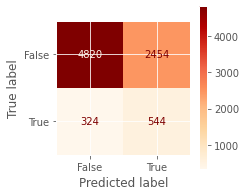

In [52]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred, labels = pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(cmap="OrRd");

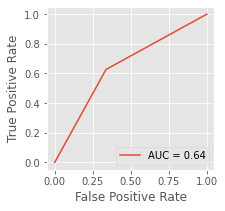

In [53]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=None)
display.plot()
plt.show()

# RUSBoost

In [54]:
from imblearn.ensemble import RUSBoostClassifier

In [55]:
# # without random oversampling
X_train = df_train.drop(target, axis=1)
y_train = df_train[target]

# with random oversampling
# X_train = df_train_oversampled.drop(target, axis=1)
# y_train = df_train_oversampled[target]

#test data
X_test = df_test.drop(target, axis=1)
y_test = df_test[target]

In [66]:
pipeline = make_pipeline(
    ColumnConverter(), #Does quick clean up, assigns datatypes and categories
    custom_oe(), #Handles encoding of ordinal variable
    SelectColumns(cols=selected_features),
    preprocessor, #uses preprocessor defined above
    RUSBoostClassifier(base_estimator=RandomForestClassifier(max_depth=10,
                                      class_weight="balanced",
                                      random_state=42, n_jobs=-1,
                                      n_estimators = 100,
                                      criterion = 'gini',
                                      max_features = 'auto',
                                      bootstrap = False),
                       n_estimators=100,
                       learning_rate=0.1,
                       algorithm='SAMME.R',
                       sampling_strategy='auto',
                       replacement=False,
                       random_state=42),
)
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print("f1 score: %s" % (f1_score(y_test, y_pred)))
print("recall score: %s" % (recall_score(y_test, y_pred)))
print("precision score: %s" % (precision_score(y_test, y_pred)))
print("discrimination results:")

f1 score: 0.28730003264773096
recall score: 0.5069124423963134
precision score: 0.20045558086560364
discrimination results:


In [67]:
verify_no_discrimination(X_test=X_test, y_true=y_test, y_pred=y_pred, sensitive_columns = ['medical_specialty', 'payer_code','gender','race', 'age', 'admission_source_code'])

/home/yash/.virtualenvs/bootcamp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/yash/.virtualenvs/bootcamp/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


{'medical_specialty': [{'cardiology': 0.14736842105263157,
   'unknown': 0.2937853107344633,
   'internalmedicine': 0.23255813953488372,
   'surgery-vascular': 0.3,
   'emergency/trauma': 0.2934362934362934,
   'family/generalpractice': 0.3793103448275862,
   'obstetricsandgynecology': 0.0,
   'nephrology': 0.37333333333333335,
   'psychiatry': 0.23076923076923078,
   'pediatrics-endocrinology': 0.0,
   'surgery-cardiovascular/thoracic': 0.0,
   'pulmonology': 0.42424242424242425,
   'other': 0.34285714285714286,
   'surgery-general': 0.33333333333333326,
   'orthopedics': 0.35714285714285715,
   'urology': 0.16666666666666669,
   'oncology': 0.16666666666666666,
   'radiologist': 0.1904761904761905,
   'orthopedics-reconstructive': 0.25806451612903225,
   'physicalmedicineandrehabilitation': 0.28571428571428575,
   'neurology': 0.0,
   'gastroenterology': 0.3157894736842105,
   'surgery-neuro': 0.0,
   'hematology/oncology': 0.0,
   'pediatrics': 0.4444444444444444},
  0.4444444444444

In [68]:
plt.rcParams["figure.figsize"] = [3, 3]

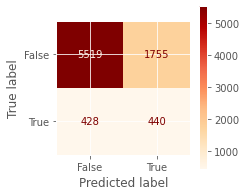

In [69]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred, labels = pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(cmap="OrRd");

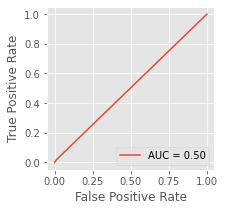

In [64]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=None)
display.plot()
plt.show()

# Output files (pickling)

In [47]:
# TMP_DIR = '/tmp'
# with open(os.path.join(TMP_DIR, "columns.json"), 'w') as fh:
#     json.dump(X_train.columns.tolist(), fh)

# with open(os.path.join(TMP_DIR, "dtypes.pickle"), 'wb') as fh:
#     pickle.dump(X_train.dtypes, fh)
    
# joblib.dump(pipeline, os.path.join(TMP_DIR, 'pipeline.pickle')) 